# Identifying relationships between annotated omics data in NMDC

In this notebook, we’ll look at how different types of omics data can be connected using popular annotation vocabularies. We’ll focus on exploring biomolecules and KEGG pathways from a group of samples that have both metagenomic and metatranscriptomic data, all available in the NMDC Data Portal. By working through these examples, you’ll see how to bring these data types together for integrated analysis.

In [3]:
%%capture
## First need to install locally the nmdc_api_utilities
%pip install nmdc_api_utilities
%pip install dotenv
%pip install plotly
%pip install kaleido
%pip install scipy


## Set up environment variables
**You can disregard this section of code unless you have interest in testing this on the development API.**

Using pythons python-dotenv package, load the environment variables from the system. This chunk of code is used in the Github CI/CD pipelines to test our development API. The variable can be used when creating `nmdc_api_utilities` objects. If you do not have the environment variable `ENV` set in a .env file, this code with default to the variable "prod" - which tells nmdc_api_utilities to use the production API URL.

In [4]:
# set up environment variables
from dotenv import load_dotenv
import os
load_dotenv()
# load the environment variable ENV. If it does not exist, default to "prod"
ENV = os.environ.get("ENV", "prod")

In [5]:
import requests
import re, sys, io, gzip, json, time, math, hashlib
import pandas as pd
import plotly.express as px, plotly.graph_objects as go
from scipy import stats
import numpy as np
from typing import Dict, List, Optional, Tuple
from io import StringIO
import nmdc_api_utilities

# Identifying relationships between annotated omics data in NMDC

This notebook is an example of how different omics data types may be linked via commonly used annotation vocabularies and investigated together. In this notebook we explore KEGG pathways and taxonomy lineage identified in a set of samples that have processed metagenomics and metatranscriptomics data available in the NMDC Data Portal.

## 1. Retrieve data from the NMDC database using API endpoints

### Choose data to retrieve

The [NMDC Data Portal](https://data.microbiomedata.org/) is a powerful resource where you can search for samples by all kinds of criteria. For this example, we’ll focus on finding samples that have both metagenomics and metatranscriptomics data.  
To do this, just use the Data Type filters (the “upset plot” below the interactive map) to quickly spot the right samples. In our case, these filters lead us to samples from the study [“Jeff Blanchard’s Harvard forest soil project”](https://data.microbiomedata.org/details/study/nmdc:sty-11-8ws97026).

### Retrieve and filter data for Harvard forest soil study

The study page linked above has the NMDC study identifier in the URL: `nmdc:sty-11-8ws97026`. We will use the [nmdc_api_utilities](https://microbiomedata.github.io/nmdc_api_utilities/) package to access the data_objects/study endpoint from the [NMDC Runtime API](https://api.microbiomedata.org/docs) to retrieve all records that represent data. This includes URLs for downloading raw data files (e.g. FASTQ) as well as processed data results output by the NMDC workflows.

In [6]:
pd.set_option("display.max_rows", 6)
from nmdc_api_utilities.data_object_search import DataObjectSearch
do_client = DataObjectSearch(env=ENV)
#get all data objects associated with this study id
data = do_client.get_data_objects_for_studies(study_id='nmdc:sty-11-8ws97026')
data = pd.DataFrame(data)

#reformat data into dataframe
data_objects=[]
for index, row in data.iterrows():
    bio_id = row['biosample_id']
    row_out = pd.json_normalize(row['data_objects'])
    row_out['biosample_id'] = bio_id
    data_objects.append(row_out)

data_objects = pd.concat(data_objects).reset_index(drop=True)
display(data_objects)

del data, index, row, row_out, bio_id

,id,type,name,file_size_bytes,md5_checksum,data_object_type,was_generated_by,url,description,data_category,biosample_id
0,nmdc:dobj-11-0ebr0z48,nmdc:DataObject,11862.7.224581.ACGGAAC-TGTTCCG.fastq.gz,34934525960,952d3a6780ac34a03b112884ec10cdda,Metagenome Raw Reads,nmdc:dgns-11-0g2bvk46,https://data.microbiomedata.org/data/nmdc:dgns...,Metagenome Raw Reads for nmdc:dgns-11-0g2bvk46,instrument_data,nmdc:bsm-11-622k6044
1,nmdc:dobj-11-s5chx118,nmdc:DataObject,nmdc_wfrqc-11-840m6332.1_filtered.fastq.gz,31299212828,440a9bfb671ab0fea36359c715bb5f4e,Filtered Sequencing Reads,nmdc:wfrqc-11-840m6332.1,https://data.microbiomedata.org/data/nmdc:dgns...,Reads QC for nmdc:dgns-11-0g2bvk46,processed_data,nmdc:bsm-11-622k6044
2,nmdc:dobj-11-p7q8bb28,nmdc:DataObject,nmdc_wfrqc-11-840m6332.1_filterStats.txt,801,b82b37fb53861fa34a06ca201068d727,QC Statistics,nmdc:wfrqc-11-840m6332.1,https://data.microbiomedata.org/data/nmdc:dgns...,Reads QC summary for nmdc:dgns-11-0g2bvk46,processed_data,nmdc:bsm-11-622k6044
...,...,...,...,...,...,...,...,...,...,...,...
3562,nmdc:dobj-11-8pbtm711,nmdc:DataObject,Blanch_Nat_Lip_H_4_AB_O_06_NEG_25Jan18_Brandi-...,12668,da7f3a98506322255816e3c2507a11e9,Configuration toml,nmdc:wfmb-11-g1vtvp02.1,https://nmdcdemo.emsl.pnnl.gov/lipidomics/blan...,CoreMS parameters used for Lipidomics workflow.,workflow_parameter_data,nmdc:bsm-11-y52p4f86
3563,nmdc:dobj-11-869nnh02,nmdc:DataObject,Blanch_Nat_Lip_H_4_AB_O_06_NEG_25Jan18_Brandi-...,853274930,946f895d2a641e9dac6cd927715df3b8,LC-MS Lipidomics Processed Data,nmdc:wfmb-11-g1vtvp02.1,https://nmdcdemo.emsl.pnnl.gov/lipidomics/blan...,CoreMS hdf5 file representing a lipidomics dat...,processed_data,nmdc:bsm-11-y52p4f86
3564,nmdc:dobj-11-zrzcp186,nmdc:DataObject,Blanch_Nat_Lip_H_4_AB_O_06_NEG_25Jan18_Brandi-...,31914586,5ec14469476f651fceaf2ec5068ad140,LC-MS Lipidomics Results,nmdc:wfmb-11-g1vtvp02.1,https://nmdcdemo.emsl.pnnl.gov/lipidomics/blan...,Lipid annotations as a result of a lipidomics ...,processed_data,nmdc:bsm-11-y52p4f86


One way of further identifying a NMDC `DataObject` record is by looking at its slot `data_object_type` (https://microbiomedata.github.io/nmdc-schema/data_object_type/), which contains a value from `FileTypeEnum` (https://microbiomedata.github.io/nmdc-schema/FileTypeEnum/). 

We want to look at the processed data results for our two omics types of interest in this notebook. Specifically, we want the files containing KEGG Orthology, Taxonomy Lineage, and  Expression data. These expression data is available in file for metatranscriptomics data (in "Metatranscriptome Expression" data object) and annotation data are found together in the metagenomics and metatranscriptomics ( in 'Annotation KEGG Orthology' and 'Gene Phylogeny tsv') results files.

We filter for results files with the following `data_object_type` values:

| Value | Description |
|:-----:|:-----------:|
|Gene Phylogeny tsv|Tab-delimited file of gene phylogeny|
|Annotation KEGG Orthology|Tab delimited file for KO annotation|
|Metatranscriptome Expression|Read count table output|


In [7]:
# Filter to biosamples that have KO annotations, Lineage, and expression results
data_objects = data_objects.groupby('biosample_id').filter(lambda x: all(data_type in x['data_object_type'].values for data_type in [
        "Annotation KEGG Orthology",
        "Metatranscriptome Expression",
        "Gene Phylogeny tsv"
    ])).reset_index(drop=True)

# Filter to the desired results file types
results_by_biosample = data_objects[data_objects['data_object_type'].isin([
    "Annotation KEGG Orthology",
    "Metatranscriptome Expression", "Gene Phylogeny tsv"
])][['biosample_id', 'id','data_object_type', 'url']].rename(columns={'id':'output_id'}).reset_index(drop=True)

# Is there one output for each data object type for each biosample?
results_by_biosample['data_object_type'].value_counts().to_frame()

,count
data_object_type,
Annotation KEGG Orthology,64
Gene Phylogeny tsv,64
Metatranscriptome Expression,39


### Select data has both metaT and metaG analysis result
Notice that Each biosample is expected to have two lineage TSV files and two KO results. Therefore, the total count should be double the expression data count (39 × 2 = 78).  However, we only observed 64. This indicates that some biosamples contain only one type of data.  

To address this, we need to filter out those incomplete biosamples and retain only those with both metaG and metaT data for the analysis (n=25).

In [8]:
results_by_biosample["_has_metaT"] = results_by_biosample["url"].str.contains(r"nmdc:wfmt", case=False, na=False)
results_by_biosample["_has_metaG"] = results_by_biosample["url"].str.contains(r"nmdc:wfmg", case=False, na=False)

mask_annotation = results_by_biosample["data_object_type"] == "Annotation KEGG Orthology"
mask_lineage = results_by_biosample["data_object_type"] == "Gene Phylogeny tsv"

results_by_biosample.loc[results_by_biosample["_has_metaT"] & mask_annotation, "data_object_type"] = "MetaT Annotation KEGG Orthology"
results_by_biosample.loc[results_by_biosample["_has_metaG"] & mask_annotation, "data_object_type"] = "MetaG Annotation KEGG Orthology"
results_by_biosample.loc[results_by_biosample["_has_metaT"] & mask_lineage, "data_object_type"] = "MetaT Gene Phylogeny tsv"
results_by_biosample.loc[results_by_biosample["_has_metaG"] & mask_lineage, "data_object_type"] = "MetaG Gene Phylogeny tsv"

# Per-biosample aggregates
agg = results_by_biosample.groupby(results_by_biosample["biosample_id"]).agg(
    rows_per_biosample=("biosample_id", "size"),
    has_metaT=("_has_metaT", "any"),
    has_metaG=("_has_metaG", "any"),
    metaT_row_count=("_has_metaT", "sum"),
    metaG_row_count=("_has_metaG", "sum"),
).reset_index()
# Classify
def classify(row):
    if row["has_metaT"] and row["has_metaG"]:
        return "both_metaT_and_metaG"
    elif row["has_metaT"] and not row["has_metaG"]:
        return "metaT_only"
    elif row["has_metaG"] and not row["has_metaT"]:
        return "metaG_only"
    else:
        return "neither"
agg["category"] = agg.apply(classify, axis=1)



counts = (
    agg["category"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "category", "category": "count"})
)

print(counts)


# Filter to keep only biosamples with both
keep_ids = set(agg.loc[agg["category"] == "both_metaT_and_metaG", "biosample_id"])
drop_ids = set(agg.loc[agg["category"] != "both_metaT_and_metaG", "biosample_id"])
filtered_results_by_biosample = results_by_biosample[results_by_biosample["biosample_id"].isin(keep_ids)].drop(columns=["_has_metaT", "_has_metaG"])
wide = filtered_results_by_biosample.pivot(index="biosample_id", columns="data_object_type", values="url").reset_index()
wide.head(10)

                  count  count
0  both_metaT_and_metaG     25
1            metaT_only     14


data_object_type,biosample_id,MetaG Annotation KEGG Orthology,MetaG Gene Phylogeny tsv,MetaT Annotation KEGG Orthology,MetaT Gene Phylogeny tsv,Metatranscriptome Expression
0,nmdc:bsm-11-042nd237,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...
1,nmdc:bsm-11-3p2mnz08,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...
2,nmdc:bsm-11-622k6044,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...
...,...,...,...,...,...,...
7,nmdc:bsm-11-7m09me46,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...
8,nmdc:bsm-11-7twwzs96,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...
9,nmdc:bsm-11-8rn9bm20,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...,https://data.microbiomedata.org/data/nmdc:dgns...


After filtering out those incomplete biosamples and retaining only those with both metaG and metaT data for the analysis (n=25), we can use `nmdc_api_utilities` to retrieve the associated metadata for these biosamples and these will be used for downstream analysis.

In [29]:
from nmdc_api_utilities.biosample_search import BiosampleSearch

biosample_search = BiosampleSearch(env=ENV)
biosample_records = [biosample_search.get_record_by_id(id_) for id_ in wide['biosample_id'].unique().tolist()]
def extract_value(value):
    if isinstance(value, dict) and 'has_raw_value' in value:
        return value['has_raw_value']
    return value

def biosample_records_to_table(biosample_records):
    rows = []
    for data in biosample_records:
        flat_data = {k: extract_value(v) for k, v in data.items()}
        rows.append(flat_data)
    df = pd.DataFrame(rows).rename(columns={"id":"biosample_id"})
    return df

biosample_metadata = biosample_records_to_table(biosample_records)
display(biosample_metadata)
biosample_metadata.to_csv('biosample_metadata.csv', index=False)

,biosample_id,type,name,associated_studies,env_broad_scale,env_local_scale,env_medium,samp_name,collection_date,depth,...,geo_loc_name,growth_facil,lat_lon,samp_store_temp,specific_ecosystem,store_cond,analysis_type,gold_biosample_identifiers,experimental_factor,sample_link
0,nmdc:bsm-11-042nd237,nmdc:Biosample,BW-C-7-M,[nmdc:sty-11-8ws97026],forest biome [ENVO:01000174],mineral horizon [ENVO:03600011],forest soil [ENVO:00002261],BW-C-7-M,2017-05-24,.02 -.10,...,"USA: Massachusetts, Petersham",field_incubation,42.481016 -72.178343,-80 Celsius,Mineral soil,frozen,"[metatranscriptomics, metagenomics, natural or...","[gold:Gb0157193, gold:Gb0158505]",NaN,NaN
1,nmdc:bsm-11-3p2mnz08,nmdc:Biosample,Inc-BW-H-2-O,[nmdc:sty-11-8ws97026],forest biome [ENVO:01000174],organic horizon [ENVO:03600018],heat stressed soil [ENVO:00005781],Inc-BW-H-2-O,2017-05-24,0 - .02,...,"USA: Massachusetts, Petersham",lab_incubation,42.481016 -72.178343,-80 Celsius,O horizon/Organic,frozen,"[metagenomics, metatranscriptomics]",[gold:Gb0157188],dideuterium oxide [CHEBI:41981],[nmdc:bsm-11-127y7152]
2,nmdc:bsm-11-622k6044,nmdc:Biosample,BW-C-12-M,[nmdc:sty-11-8ws97026],forest biome [ENVO:01000174],mineral horizon [ENVO:03600011],forest soil [ENVO:00002261],BW-C-12-M,2017-05-24,.02 -.10,...,"USA: Massachusetts, Petersham",field_incubation,42.481016 -72.178343,-80 Celsius,Mineral soil,frozen,"[metatranscriptomics, metagenomics, natural or...","[gold:Gb0157185, gold:Gb0158500]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,nmdc:bsm-11-wrvmh591,nmdc:Biosample,Inc-BW-H-32-O,[nmdc:sty-11-8ws97026],forest biome [ENVO:01000174],organic horizon [ENVO:03600018],heat stressed soil [ENVO:00005781],Inc-BW-H-32-O,2017-05-24,0 - .02,...,"USA: Massachusetts, Petersham",lab_incubation,42.481016 -72.178343,-80 Celsius,O horizon/Organic,frozen,"[metagenomics, metatranscriptomics]",[gold:Gb0157177],dideuterium oxide [CHEBI:41981],[nmdc:bsm-11-k4wb6c34]
23,nmdc:bsm-11-xtz7he28,nmdc:Biosample,Inc-BW-H-17-O,[nmdc:sty-11-8ws97026],forest biome [ENVO:01000174],organic horizon [ENVO:03600018],heat stressed soil [ENVO:00005781],Inc-BW-H-17-O,2017-05-24,0 - .02,...,"USA: Massachusetts, Petersham",lab_incubation,42.481016 -72.178343,-80 Celsius,O horizon/Organic,frozen,"[metagenomics, metatranscriptomics]",[gold:Gb0157187],dideuterium oxide [CHEBI:41981],[nmdc:bsm-11-fmvr0890]
24,nmdc:bsm-11-xxvfda22,nmdc:Biosample,BW-H-2-M,[nmdc:sty-11-8ws97026],forest biome [ENVO:01000174],mineral horizon [ENVO:03600011],heat stressed soil [ENVO:00005781],BW-H-2-M,2017-05-24,.02 -.10,...,"USA: Massachusetts, Petersham",field_incubation,42.481016 -72.178343,-80 Celsius,Mineral soil,frozen,"[metatranscriptomics, metagenomics, natural or...","[gold:Gb0157175, gold:Gb0158483]",heat stress treatment [MCO:0000172],NaN


### Download selected results files
 
Now we can use the `url` slots from the filtered `DataObject` records to read in all of the files containing the annotations of interest and stored in a `datastore` data structure.
* datastore['biosample_id']['metag_ko_results']
* datastore['biosample_id']['metat_ko_results'] 
* datastore['biosample_id']['metag_lineage_results']
* datastore['biosample_id']['metat_lineage_results'] 
* datastore['biosample_id']['metat_expression_results'] 

In [ ]:
# Ingest into per-sample datastore
ko_columns = ["gene_id", "img_ko_flag", "ko_term", "percent_identity",
              "query_start", "query_end", "subj_start", "subj_end",
              "evalue", "bit_score", "align_length"]
lineage_columns = ["gene_id", "homolog_gene_oid", "homolog_taxon_oid", "percent_identity","lineage"]

# Function to read TSV files
def read_tsv_from_url(url:str, column_names:None):
    response = requests.get(url)
    if column_names is None:
        data = pd.read_csv(StringIO(response.text), sep='\t')
    else:
        data = pd.read_csv(StringIO(response.text), sep='\t', header=None, names=column_names)
    return data

def load_sample_row(row: pd.Series) -> Dict[str, Optional[pd.DataFrame]]:
    col_map = {
        "MetaG Annotation KEGG Orthology": ("metag_ko_results", ko_columns),
        "MetaT Annotation KEGG Orthology": ("metat_ko_results", ko_columns),
        "MetaG Gene Phylogeny tsv": ("metag_lineage_results", lineage_columns),
        "MetaT Gene Phylogeny tsv": ("metat_lineage_results", lineage_columns),
        "Metatranscriptome Expression": ("metat_expression_results", None),
    }
    out = {}
    for col, (key, cols) in col_map.items():
        url = row.get(col, np.nan)
        out[key] = read_tsv_from_url(str(url), cols) if pd.notnull(url) else None
    return out

def build_datastore(wide_df: pd.DataFrame) -> Dict[str, Dict[str, Optional[pd.DataFrame]]]:
    store = {}
    for _, row in wide_df.iterrows():
        biosample_id = str(row["biosample_id"])
        store[biosample_id] = load_sample_row(row)
    return store

datastore = build_datastore(wide)
len(datastore)


In [11]:
# check total number of biosamples
print("# of biosamples: ", len(datastore))
# View a snippet of the metagenome KEGG Orthology annotations file
datastore[next(iter(datastore))]['metag_ko_results'].head(3)

# of biosamples:  25


,gene_id,img_ko_flag,ko_term,percent_identity,query_start,query_end,subj_start,subj_end,evalue,bit_score,align_length
0,nmdc:wfmgan-11-fw38xr59.1_0000001_16096_17001,2574333214,KO:K11936,61.54,1,286,1,283,2.000000e-124,414.0,286
1,nmdc:wfmgan-11-fw38xr59.1_0000001_22302_23399,2524282950,KO:K02335,30.08,14,274,8,239,5.700000e-14,87.1,261
2,nmdc:wfmgan-11-fw38xr59.1_0000001_25193_26839,646747065,KO:K00525,61.61,3,548,18,564,1.500000e-249,796.0,546


## 2. KEGG Orthology (KO) Analysis
### Shared vs unique KOs (MetaG vs MetaT)
 
Metagenomic and metatranscriptome results in NMDC both include KEGG Orthology (KO) annotations. This allows us to compare the shared and unique KOs between the two data types across biosamples.

Technically, we parse the KO TSV files for both MetaG and MetaT, standardize the KO IDs (Kxxxxx format), and calculate the following for each biosample:

 * Number of MetaG KOs (n_metag_ko)
 * Number of MetaT KOs (n_metat_ko)
 * Number of shared KOs (n_shared_ko)
 * Number unique to MetaG (n_metag_only)
 * Number unique to MetaT (n_metat_only)
 * Jaccard index

Additionally, we generate a Plotly stacked bar chart to visualize the comparison of shared and unique KOs for each biosample. We also create a violin plot or stacked bar chart to compare the distribution of shared KOs across different ecosystems.

In [12]:
# 1) Shared/unique KO annotations
OUTPUT_DIR=os.getcwd()  # specify your desired output directory here
def extract_ko_id(x: Optional[str]) -> Optional[str]:
    if not isinstance(x, str):
        return None
    m = re.search(r"K\d{5}", x.upper())
    return m.group(0) if m else None
def standardize_ko_df(df_ko: pd.DataFrame) -> pd.DataFrame:
    if df_ko is None or len(df_ko) == 0:
        return pd.DataFrame(columns=["gene_id", "ko_id", "ko_term"])
    for needed in ["gene_id", "ko_term"]:
        if needed not in df_ko.columns:
            raise ValueError(f"KO file missing required column: {needed}.")
    out = df_ko.copy()
    out["ko_id"] = out["ko_term"].map(extract_ko_id)
    out = out.dropna(subset=["ko_id"]).copy()
    out["gene_id"] = out["gene_id"].astype(str)
    return out[["gene_id", "ko_id", "ko_term"]].drop_duplicates()

def shared_ko_stats_per_sample(datastore):
    rows = []
    for biosample_id, items in datastore.items():
        metag = standardize_ko_df(items.get("metag_ko_results"))
        metat = standardize_ko_df(items.get("metat_ko_results"))
        mg = set(metag["ko_id"].dropna().unique())
        mt = set(metat["ko_id"].dropna().unique())
        shared = mg & mt
        rows.append({
            "biosample_id": biosample_id,
            "n_metag_ko": len(mg),
            "n_metat_ko": len(mt),
            "n_shared_ko": len(shared),
            "n_metag_only": len(mg - mt),
            "n_metat_only": len(mt - mg),
            "jaccard": (len(shared)/len(mg|mt)) if (mg or mt) else float("nan"),
        })
    return pd.DataFrame(rows)

ko_overlap_df = shared_ko_stats_per_sample(datastore)
ko_overlap_df.to_csv(os.path.join(OUTPUT_DIR, "ko_overlap_summary.csv"), index=False)
ko_overlap_df.head(20)

,biosample_id,n_metag_ko,n_metat_ko,n_shared_ko,n_metag_only,n_metat_only,jaccard
0,nmdc:bsm-11-042nd237,9520,9888,8311,1209,1577,0.748941
1,nmdc:bsm-11-3p2mnz08,9485,8143,7244,2241,899,0.697612
2,nmdc:bsm-11-622k6044,9101,9447,7790,1311,1657,0.724112
...,...,...,...,...,...,...,...
17,nmdc:bsm-11-hebdaz02,9268,8328,7396,1872,932,0.725098
18,nmdc:bsm-11-ncyddq48,9415,7030,6523,2892,507,0.657428
19,nmdc:bsm-11-nq2tfm26,7844,7468,6119,1725,1349,0.665615


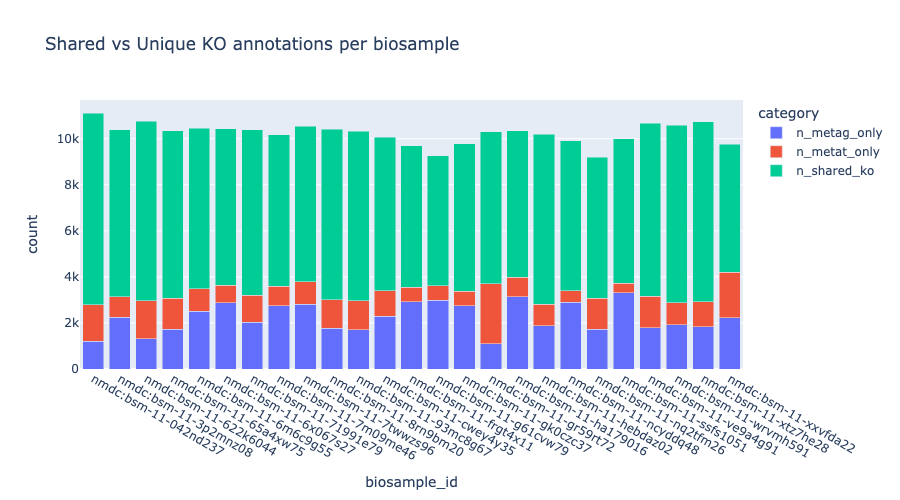

In [48]:
# Plot: stacked bar chart shared vs unique
if len(ko_overlap_df):
    df_long = ko_overlap_df.melt(id_vars=["biosample_id"], value_vars=["n_metag_only", "n_metat_only", "n_shared_ko"],
                                 var_name="category", value_name="count")
    fig = px.bar(df_long, x="biosample_id", y="count", color="category", barmode="stack",
                 title="Shared vs Unique KO annotations per biosample")
    fig.write_html(os.path.join(OUTPUT_DIR, "plot_shared_ko_barchart.html"), include_plotlyjs="cdn", full_html=True)
fig.show(renderer="png",width=900) if len(ko_overlap_df) else None


This figure indicates that a substantial portion of the metagenomic functional potential is actively expressed, while the metagenome also contains many KOs with no corresponding transcripts (possibly dormant or low-expression genes). Likewise, a number of KOs appear only in the metatranscriptome, which could arise from highly expressed genes of low abundance organisms or unassembled genomic fragments. Some “metatranscriptome-only KOs” could actually be present in DNA but missing from metagenomic assemblies due to coverage gaps, strain variation, or assembly fragmentation.

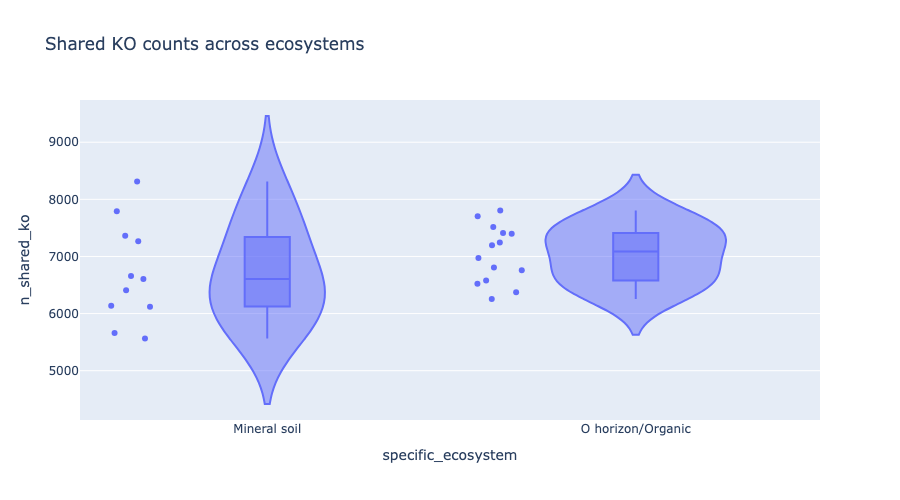

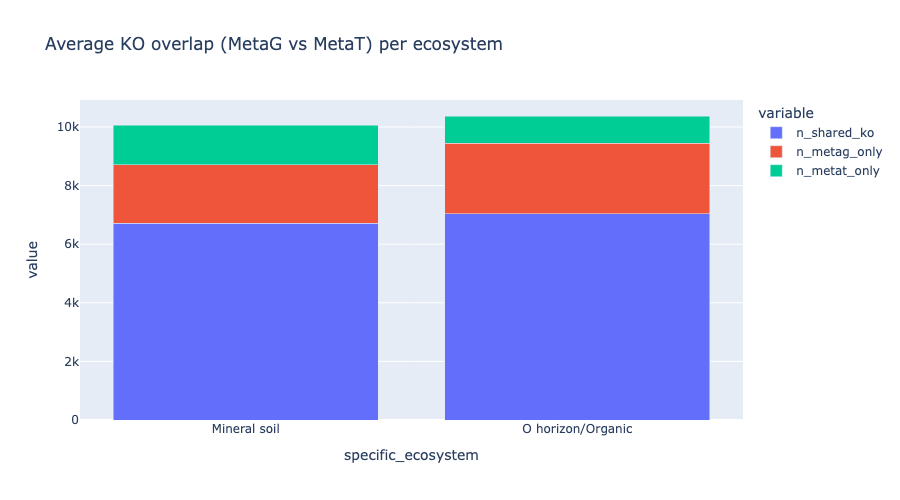

In [47]:
ko_with_meta = ko_overlap_df.merge(biosample_metadata[["biosample_id", "specific_ecosystem"]], on="biosample_id", how="left")
# KO overlap differences across ecosystems
if len(ko_with_meta):
    fig = px.violin(ko_with_meta, x="specific_ecosystem", y="n_shared_ko", box=True, points="all",
                    title="Shared KO counts across ecosystems")
    fig.show(renderer="png",width=900)

    eco_summary = (ko_with_meta.groupby("specific_ecosystem")[["n_shared_ko","n_metag_only","n_metat_only"]]
                   .mean().reset_index())
    fig2 = px.bar(eco_summary.melt(id_vars="specific_ecosystem", 
                                   value_vars=["n_shared_ko","n_metag_only","n_metat_only"]),
                  x="specific_ecosystem", y="value", color="variable", barmode="stack",
                  title="Average KO overlap (MetaG vs MetaT) per ecosystem")
    fig2.show(renderer="png",width=900)

Violin plot of shared KO counts across ecosystems shows the distribution of the number of shared KOs (MetaG ∩ MetaT) for each biosample within ecosystems.

* Functional overlap between potential (DNA) and activity (RNA) is relatively consistent across ecosystems, but variability is greater in mineral soils, perhaps reflecting more heterogeneous communities or microenvironments.
* With slightly higher shared KO counts on average, organic soils may support more consistently active functional repertoires due to richer nutrient availability and microbial activity.

Stacked bar chart of average KO categories per ecosystem

* Both ecosystems show a strong backbone of shared functions.
* Mineral soils → bias toward transcriptome-only functions (active niche-specialized expression).
* Organic soils → bias toward metagenome-only functions (large reservoir of potential functions not currently expressed).


## 3. KEGG Pathway Analysis

Next, we use the KEGG API to look up KO annotations and determine their corresponding pathways in KEGG.

We calcudate KEGG pathway coverage & expression across biosamples:

* Aggregate MetaT expression data at the pathway level and summarize coverage for each pathway and sample:

	* Number of MetaG KOs (n_metag_kos)
	* Number of MetaT KOs (n_metat_kos)
	* Number of shared KOs (n_shared_kos)

* Generate Plotly heatmaps to visualize:

    * Pathway expression (log1p-transformed expression values)
	* Pathway coverage (counts of shared or modality-specific KOs)

* Statistics across biosamples and pathways:

	* Perform non-parametric Kruskal–Wallis testing to compare pathway expression distributions across biosamples, with Benjamini–Hochberg FDR correction.

* Visualize top pathways by expression using Plotly violin or box plots.

In [ ]:

# 2) KEGG pathway mapping & coverage / expression
RUN_KEGG_MAPPING=True
CACHE_DIR=os.getcwd() 
def kegg_link_ko_to_pathways(ko_ids: List[str]) -> pd.DataFrame:
    ko_ids = sorted(set([k for k in ko_ids if isinstance(k, str) and re.match(r"K\d{5}", k)]))
    if not ko_ids:
        return pd.DataFrame(columns=["ko_id", "pathway_id"])
    cache_map_path = os.path.join(CACHE_DIR, "kegg_ko_pathway_map.tsv")
    cached = pd.read_csv(cache_map_path, sep="\t", dtype=str) if os.path.exists(cache_map_path) else pd.DataFrame(columns=["ko_id", "pathway_id"])
    cached_set = set(map(tuple, cached[["ko_id","pathway_id"]].dropna().itertuples(index=False, name=None)))
    missing = []
    for k in ko_ids:
        if not any(row[0]==k for row in cached_set): missing.append(k)
    new_rows = []
    if RUN_KEGG_MAPPING and missing:
        import requests
        for k in missing:
            try:
                url = f"https://rest.kegg.jp/link/pathway/ko:{k}"
                resp = requests.get(url, timeout=30)
                if resp.status_code==200:
                    for line in resp.text.strip().splitlines():
                        parts=line.split("\t")
                        if len(parts)==2:
                            ko_part = parts[0].split(":")[-1].strip().upper()
                            path_part = parts[1].split(":")[-1].strip()
                            new_rows.append((ko_part, path_part))
            except Exception as e:
                print("[KEGG] error", k, e)
        if new_rows:
            add_df = pd.DataFrame(new_rows, columns=["ko_id","pathway_id"])
            cached = pd.concat([cached, add_df], ignore_index=True).drop_duplicates()
            cached.to_csv(cache_map_path, sep="\t", index=False)
    return cached[cached["ko_id"].isin(ko_ids)].drop_duplicates()

def kegg_pathway_names(pathway_ids: List[str]) -> pd.DataFrame:
    pathway_ids = sorted(set([p for p in pathway_ids if isinstance(p, str) and re.match(r"map\d{5}", p)]))
    if not pathway_ids:
        return pd.DataFrame(columns=["pathway_id","pathway_name"])
    cache_names_path = os.path.join(CACHE_DIR, "kegg_pathway_names.tsv")
    cached = pd.read_csv(cache_names_path, sep="\t", dtype=str) if os.path.exists(cache_names_path) else pd.DataFrame(columns=["pathway_id","pathway_name"])
    cached_dict = dict(zip(cached["pathway_id"], cached["pathway_name"]))
    missing = [p for p in pathway_ids if p not in cached_dict]
    new_rows = []
    if RUN_KEGG_MAPPING and missing:
        import requests
        for p in missing:
            try:
                url = f"https://rest.kegg.jp/list/{p}"
                resp = requests.get(url, timeout=30)
                if resp.status_code==200:
                    first = resp.text.strip().splitlines()[0]
                    parts = first.split("\t")
                    if len(parts)==2:
                        new_rows.append((p, parts[1]))
            except Exception as e:
                print("[KEGG] name error", p, e)
        if new_rows:
            add_df = pd.DataFrame(new_rows, columns=["pathway_id","pathway_name"])
            cached = pd.concat([cached, add_df], ignore_index=True).drop_duplicates()
            cached.to_csv(cache_names_path, sep="\t", index=False)
    return cached[cached["pathway_id"].isin(pathway_ids)].drop_duplicates()

def build_ko_to_pathway_mapping(datastore):
    all_kos = set()
    for items in datastore.values():
        for key in ["metag_ko_results","metat_ko_results"]:
            dfk = standardize_ko_df(items.get(key))
            all_kos.update(dfk["ko_id"].dropna().unique().tolist())
    all_kos = sorted(all_kos)
    if not all_kos: return pd.DataFrame(columns=["ko_id","pathway_id","pathway_name"])
    ko2path = kegg_link_ko_to_pathways(all_kos)
    path_names = kegg_pathway_names(ko2path["pathway_id"].unique().tolist()) if len(ko2path) else pd.DataFrame(columns=["pathway_id","pathway_name"])
    return ko2path.merge(path_names, on="pathway_id", how="left")

ko_path_map = build_ko_to_pathway_mapping(datastore)
ko_path_map.head(10)


In [15]:

def parse_expression_df(df_expr: pd.DataFrame) -> pd.DataFrame:
    gene_col = "img_gene_oid"
    expr_col = "reads_cnt"
    OUT_gene_col = "gene_id"
    OUT_expr_col = "expr_value"

    if df_expr is None or len(df_expr) == 0:
        return pd.DataFrame(columns=[OUT_gene_col, OUT_expr_col])
    df = df_expr.copy()
    
    out = df[[gene_col, expr_col]].copy()
    out.columns = [OUT_gene_col, OUT_expr_col]
    out[OUT_expr_col] = pd.to_numeric(out[OUT_expr_col], errors="coerce")
    out = out.dropna(subset=[OUT_gene_col]).copy()
    out[OUT_gene_col] = out[OUT_gene_col].astype(str)
    out = out.groupby(OUT_gene_col, as_index=False)[OUT_expr_col].sum()
    return out

def compute_pathway_expression_coverage(datastore, ko_path_map):
    rows_expr, rows_presence = [], []
    for biosample_id, items in datastore.items():
        metag = standardize_ko_df(items.get("metag_ko_results"))
        metat = standardize_ko_df(items.get("metat_ko_results"))
        expr  = parse_expression_df(items.get("metat_expression_results"))
        if len(metat) and len(expr):
            metat_expr = metat.merge(expr, left_on="gene_id", right_on="gene_id", how="left")
        else:
            metat_expr = pd.DataFrame(columns=["gene_id","ko_id","ko_term","expr_value"])

        if len(ko_path_map)==0: continue

        mg_kos = set(metag["ko_id"].unique().tolist())
        mt_kos = set(metat["ko_id"].unique().tolist())
        sh_kos = mg_kos & mt_kos

        for path_id, sub in ko_path_map.groupby("pathway_id"):
            p_name = sub["pathway_name"].dropna().iloc[0] if "pathway_name" in sub.columns and sub["pathway_name"].notna().any() else path_id
            path_kos = set(sub["ko_id"].unique().tolist())
            rows_presence.append({
                "biosample_id": biosample_id,
                "pathway_id": path_id, "pathway_name": p_name,
                "n_metag_kos": len(path_kos & mg_kos),
                "n_metat_kos": len(path_kos & mt_kos),
                "n_shared_kos": len(path_kos & sh_kos),
            })

        if len(metat_expr):
            metat_expr_by_ko = metat_expr.groupby("ko_id", as_index=False)["expr_value"].sum()
            joined = metat_expr_by_ko.merge(ko_path_map[["ko_id","pathway_id","pathway_name"]].drop_duplicates(),
                                            on="ko_id", how="left")
            grouped = joined.groupby(["pathway_id","pathway_name"], as_index=False)["expr_value"].sum()
            for _, r in grouped.iterrows():
                rows_expr.append({
                    "biosample_id": biosample_id,
                    "pathway_id": r["pathway_id"],
                    "pathway_name": r["pathway_name"],
                    "expr_sum": float(r["expr_value"]),
                })
    return pd.DataFrame(rows_expr), pd.DataFrame(rows_presence)

pathway_expr, pathway_presence = compute_pathway_expression_coverage(datastore, ko_path_map)
pathway_expr.to_csv(os.path.join(OUTPUT_DIR, "pathway_expression_by_sample.csv"), index=False)
pathway_presence.to_csv(os.path.join(OUTPUT_DIR, "pathway_presence_by_sample.csv"), index=False)
(pathway_expr.head(10), pathway_presence.head(10))


(            biosample_id pathway_id  \
 0   nmdc:bsm-11-042nd237   map00010   
 1   nmdc:bsm-11-042nd237   map00020   
 2   nmdc:bsm-11-042nd237   map00030   
 ..                   ...        ...   
 7   nmdc:bsm-11-042nd237   map00061   
 8   nmdc:bsm-11-042nd237   map00062   
 9   nmdc:bsm-11-042nd237   map00071   
 
                                    pathway_name  expr_sum  
 0   Glycolysis / Gluconeogenesis [PATH:ko00010]  327421.0  
 1      Citrate cycle (TCA cycle) [PATH:ko00020]  245707.0  
 2      Pentose phosphate pathway [PATH:ko00030]  181284.0  
 ..                                          ...       ...  
 7        Fatty acid biosynthesis [PATH:ko00061]  150937.0  
 8          Fatty acid elongation [PATH:ko00062]    1820.0  
 9         Fatty acid degradation [PATH:ko00071]  157872.0  
 
 [10 rows x 4 columns],
             biosample_id pathway_id  \
 0   nmdc:bsm-11-042nd237   map00010   
 1   nmdc:bsm-11-042nd237   map00020   
 2   nmdc:bsm-11-042nd237   map00030   
 .. 

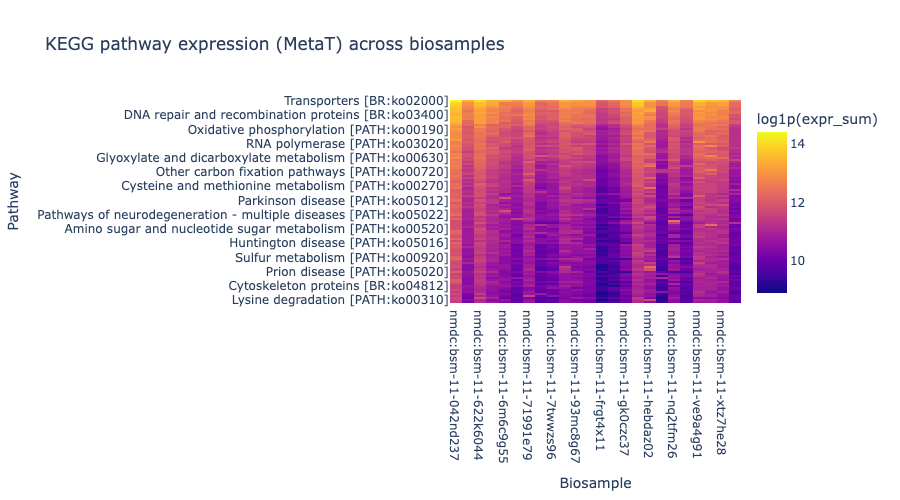

In [46]:
# Heatmaps
if len(pathway_expr):
    mat = pathway_expr.copy()
    mat["log_expr"] = np.log1p(mat["expr_sum"].astype(float))
    heat = mat.pivot_table(index="pathway_name", columns="biosample_id", values="log_expr", fill_value=0.0).sort_index()
    # Sort pathway by sum of log_expr across all biosamples (descending)
    pathway_order = heat.sum(axis=1).sort_values(ascending=False).index
    heat = heat.loc[pathway_order]
    fig = px.imshow(heat[:100], labels=dict(x="Biosample", y="Pathway", color="log1p(expr_sum)"),aspect='auto',
                    title="KEGG pathway expression (MetaT) across biosamples")
    fig.write_html(os.path.join(OUTPUT_DIR, "heatmap_pathway_expression.html"), include_plotlyjs="cdn", full_html=True)
    fig.show(renderer="png",width=900)  # use renderer="png" to show in some environments
else:
    None


In [ ]:
# Statistics: Kruskal–Wallis across biosamples (per pathway)
def kruskal_wallis_across_samples(pathway_expr: pd.DataFrame) -> pd.DataFrame:
    if pathway_expr is None or len(pathway_expr) == 0:
        return pd.DataFrame(columns=["pathway_id","pathway_name","p_value","q_value","n_samples"])
    results = []
    for path_id, grp in pathway_expr.groupby("pathway_id"):
        vectors = [sub["expr_sum"].astype(float).values for _, sub in grp.groupby("biosample_id")]
        if len(vectors) >= 2 and all(len(v) > 0 for v in vectors):
            try:
                stat, p = stats.kruskal(*vectors)
            except Exception:
                p = np.nan
            results.append((path_id, grp["pathway_name"].dropna().iloc[0], p, len(vectors)))
    res_df = pd.DataFrame(results, columns=["pathway_id","pathway_name","p_value","n_samples"]).sort_values("p_value")
    m = res_df["p_value"].notna().sum()
    if m>0:
        ranks = res_df["p_value"].rank(method="first")
        res_df["q_value"] = res_df["p_value"] * m / ranks
        res_df["q_value"] = res_df["q_value"].clip(upper=1.0)
    else:
        res_df["q_value"] = np.nan
    return res_df.sort_values("q_value", na_position="last")

kw_df = kruskal_wallis_across_samples(pathway_expr)
kw_df.to_csv(os.path.join(OUTPUT_DIR, "stats_kruskal_pathways_across_samples.csv"), index=False)
kw_df.head(20)


,pathway_id,pathway_name,p_value,n_samples,q_value
492,map05217,Basal cell carcinoma [PATH:ko05217],0.460771,24,0.460771
161,map00996,Biosynthesis of various alkaloids [PATH:ko00996],0.460771,24,0.461629
538,map99999,Others,0.460771,24,0.462490
...,...,...,...,...,...
179,map01054,Nonribosomal peptide structures [PATH:ko01054],0.460771,24,0.475806
197,map02025,Biofilm formation - Pseudomonas aeruginosa [PA...,0.460771,24,0.476721
198,map02026,Biofilm formation - Escherichia coli [PATH:ko0...,0.460771,24,0.477639


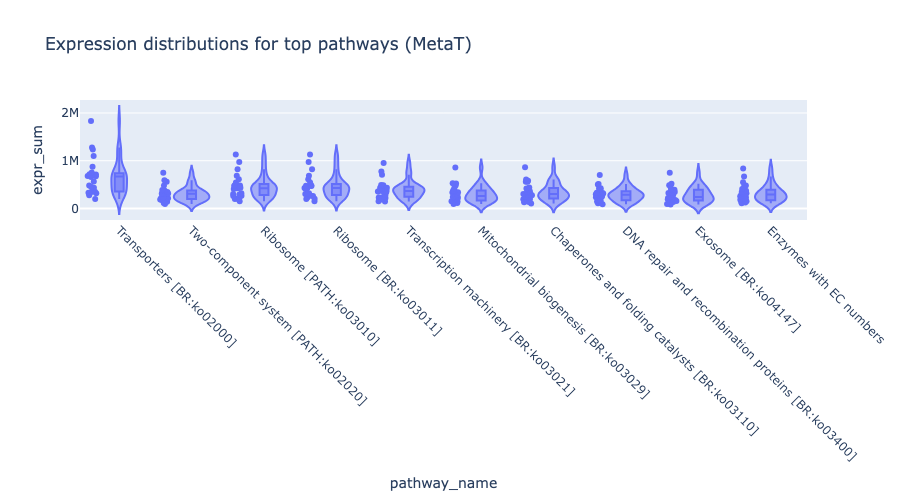

In [51]:
# Violin/Box for top pathways
if len(pathway_expr):
    ranks = (pathway_expr.groupby(["pathway_id","pathway_name"])["expr_sum"]
             .sum().sort_values(ascending=False).head(10).reset_index())
    top_ids = set(ranks["pathway_id"].tolist())
    sub = pathway_expr[pathway_expr["pathway_id"].isin(top_ids)].copy()
    fig = px.violin(sub, x="pathway_name", y="expr_sum", box=True,
                    title="Expression distributions for top pathways (MetaT)", points="all")
    fig.update_xaxes(tickangle=45)
    fig.write_html(os.path.join(OUTPUT_DIR, "violin_top_pathways.html"), include_plotlyjs="cdn", full_html=True)
    fig.show(renderer="png",width=900)
else:
    None



## 4. Taxonomy comparison: MetaG lineage vs MetaT lineage + expression

Parses lineage TSVs, splits lineage into ranks (kingdom→species).
	•	Aggregates:
	•	MetaG: gene counts per taxon (e.g., genus).
	•	MetaT: expression summed per taxon (by joining MetaT lineage to MetaT expression).
	•	Computes Spearman correlation between MetaG counts and MetaT expression across taxa per biosample.
	•	Plotly heatmaps for (e.g.) genus level:
	•	MetaG gene counts heatmap
	•	MetaT expression (log1p) heatmap

In [ ]:

# Taxonomy comparison: MetaG lineage vs MetaT lineage + expression
def parse_lineage_df(df_lin: pd.DataFrame) -> pd.DataFrame:
    if df_lin is None or len(df_lin) == 0:
        cols = ["gene_id", "lineage", "kingdom", "phylum", "class", "order", "family", "genus", "species"]
        return pd.DataFrame(columns=cols)
    if "gene_id" not in df_lin.columns or "lineage" not in df_lin.columns:
        raise ValueError("Lineage file missing gene_id or lineage column.")
    def split_lineage(s: str):
        if not isinstance(s, str): return (None,)*7
        parts = [p.strip() for p in re.split(r"[;|]\s*", s) if p.strip()]
        ranks = [None]*7
        for i in range(min(7, len(parts))): ranks[i] = parts[i]
        return tuple(ranks)
    df = df_lin[["gene_id", "lineage"]].copy()
    split_cols = df["lineage"].map(split_lineage)
    rank_df = pd.DataFrame(split_cols.tolist(), columns=["kingdom", "phylum", "class", "order", "family", "genus", "species"])
    out = pd.concat([df.reset_index(drop=True), rank_df], axis=1)
    out["gene_id"] = out["gene_id"].astype(str)
    return out

def taxonomy_vs_expression(datastore, rank="genus"):
    mg_rows, mt_rows, st_rows = [], [], []
    for biosample_id, items in datastore.items():
        mg_lin = parse_lineage_df(items.get("metag_lineage_results"))
        mt_lin = parse_lineage_df(items.get("metat_lineage_results"))
        expr   = parse_expression_df(items.get("metat_expression_results"))
        if rank not in mg_lin.columns or rank not in mt_lin.columns: continue

        if len(mg_lin):
            mg_counts = (mg_lin.dropna(subset=[rank])
                         .groupby(rank, as_index=False)["gene_id"].nunique()
                         .rename(columns={"gene_id":"count"}))
            for _, r in mg_counts.iterrows():
                mg_rows.append({"biosample_id": biosample_id, "taxon": r[rank], "count": int(r["count"])})

        if len(mt_lin) and len(expr):
            mt_join = mt_lin.merge(expr, on="gene_id", how="left")
            mt_sum = (mt_join.dropna(subset=[rank])
                      .groupby(rank, as_index=False)["expr_value"].sum()
                      .rename(columns={"expr_value":"expr_sum"}))
            for _, r in mt_sum.iterrows():
                mt_rows.append({"biosample_id": biosample_id, "taxon": r[rank], "expr_sum": float(r["expr_sum"])})

        if len(mg_lin) and len(mt_lin) and len(expr):
            mgc = (mg_lin.dropna(subset=[rank]).groupby(rank, as_index=False)["gene_id"].nunique().rename(columns={"gene_id":"count"}))
            mtj = mt_lin.merge(expr, on="gene_id", how="left")
            mts = (mtj.dropna(subset=[rank]).groupby(rank, as_index=False)["expr_value"].sum().rename(columns={"expr_value":"expr_sum"}))
            both = mgc.merge(mts, on=rank, how="inner")
            if len(both) >= 3:
                r, p = stats.spearmanr(both["count"].astype(float), both["expr_sum"].astype(float))
                st_rows.append({"biosample_id": biosample_id, "spearman_r": float(r), "p_value": float(p), "n_taxa": int(len(both))})
            else:
                st_rows.append({"biosample_id": biosample_id, "spearman_r": float("nan"), "p_value": float("nan"), "n_taxa": int(len(both))})
    mg_df = pd.DataFrame(mg_rows); mt_df = pd.DataFrame(mt_rows); st_df = pd.DataFrame(st_rows)
    mg_df.to_csv(os.path.join(OUTPUT_DIR, f"taxonomy_metaG_counts_{rank}.csv"), index=False)
    mt_df.to_csv(os.path.join(OUTPUT_DIR, f"taxonomy_metaT_expr_{rank}.csv"), index=False)
    st_df.to_csv(os.path.join(OUTPUT_DIR, f"taxonomy_spearman_{rank}.csv"), index=False)
    return mg_df, mt_df, st_df

metaG_counts_kingdom, metaT_expr_kingdom, tax_corr = taxonomy_vs_expression(datastore, rank="kingdom")
(metaG_counts_kingdom.head(10), metaT_expr_kingdom.head(10), tax_corr.head(10))
metaG_counts_phylum, metaT_expr_phylum, tax_corr = taxonomy_vs_expression(datastore, rank="phylum")
(metaG_counts_phylum.head(10), metaT_expr_phylum.head(10), tax_corr.head(10))


(            biosample_id            taxon    count
 0   nmdc:bsm-11-042nd237  Acidobacteriota  1505226
 1   nmdc:bsm-11-042nd237   Actinomycetota   882503
 2   nmdc:bsm-11-042nd237         Annelida      417
 ..                   ...              ...      ...
 7   nmdc:bsm-11-042nd237       Ascomycota    14191
 8   nmdc:bsm-11-042nd237    Atribacterota      923
 9   nmdc:bsm-11-042nd237  Bacillariophyta       45
 
 [10 rows x 3 columns],
             biosample_id            taxon   expr_sum
 0   nmdc:bsm-11-042nd237  Acidobacteriota  7300041.0
 1   nmdc:bsm-11-042nd237   Actinomycetota  2398193.0
 2   nmdc:bsm-11-042nd237         Annelida    46849.0
 ..                   ...              ...        ...
 7   nmdc:bsm-11-042nd237       Ascomycota   133237.0
 8   nmdc:bsm-11-042nd237    Atribacterota     1987.0
 9   nmdc:bsm-11-042nd237  Bacillariophyta     2037.0
 
 [10 rows x 3 columns],
             biosample_id  spearman_r       p_value  n_taxa
 0   nmdc:bsm-11-042nd237    0.671159  1

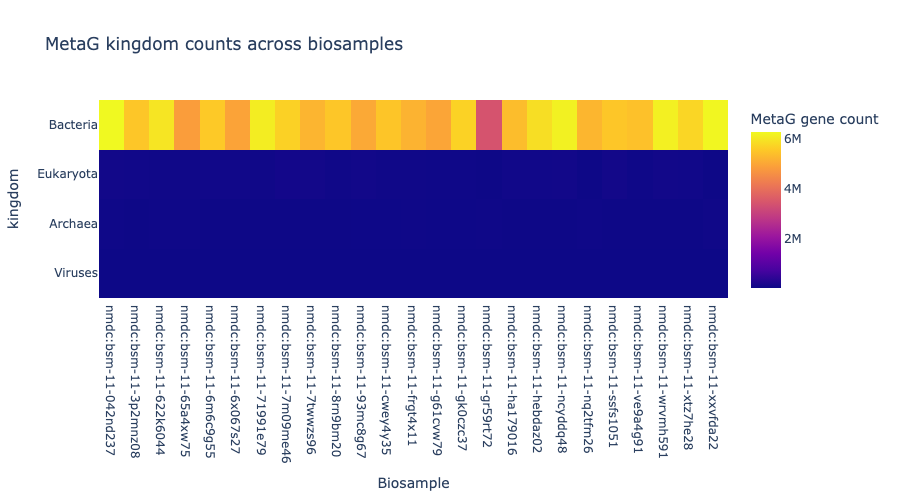

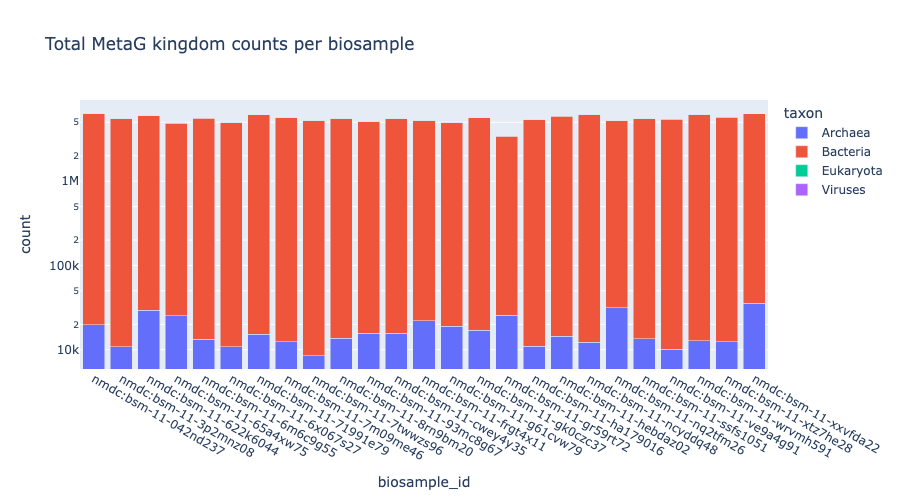

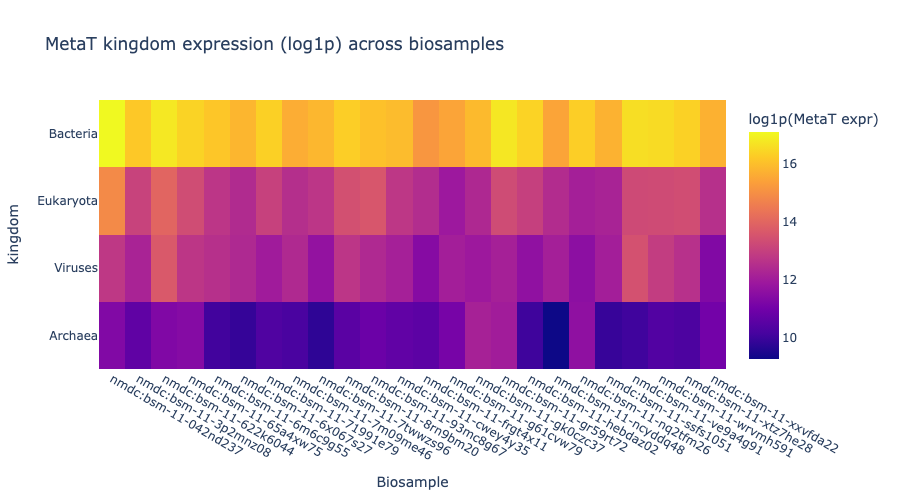

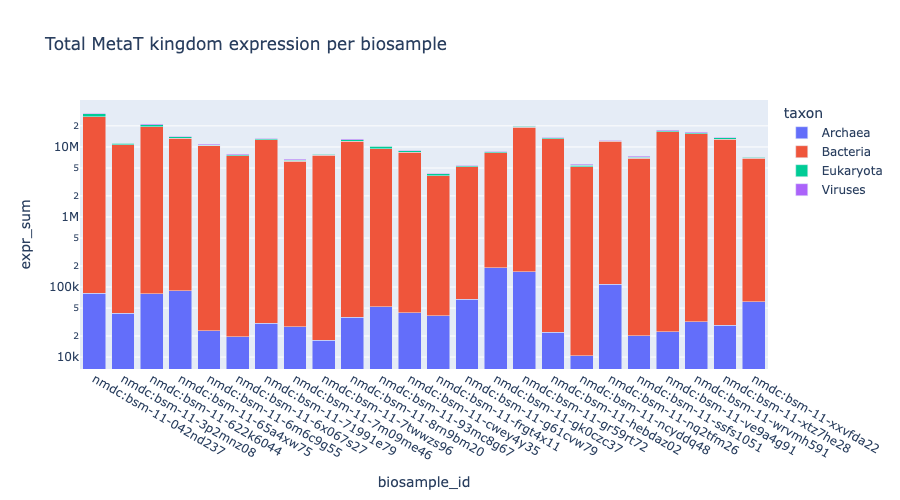

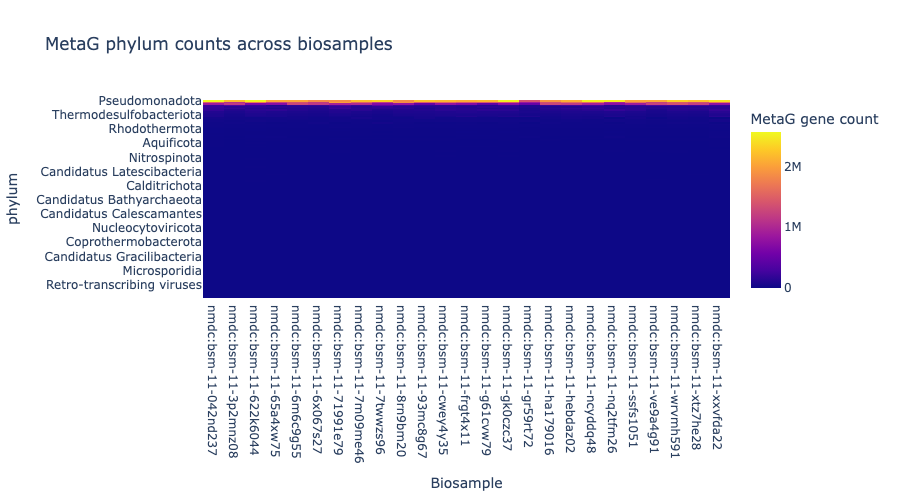

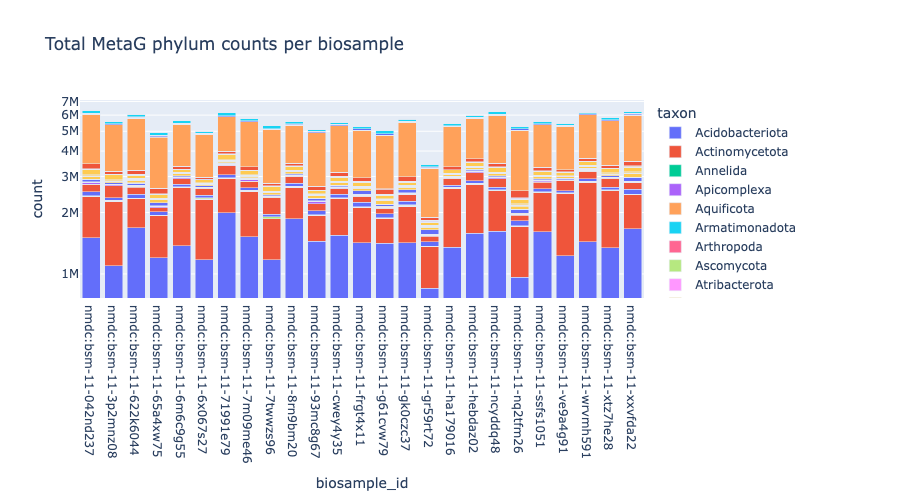

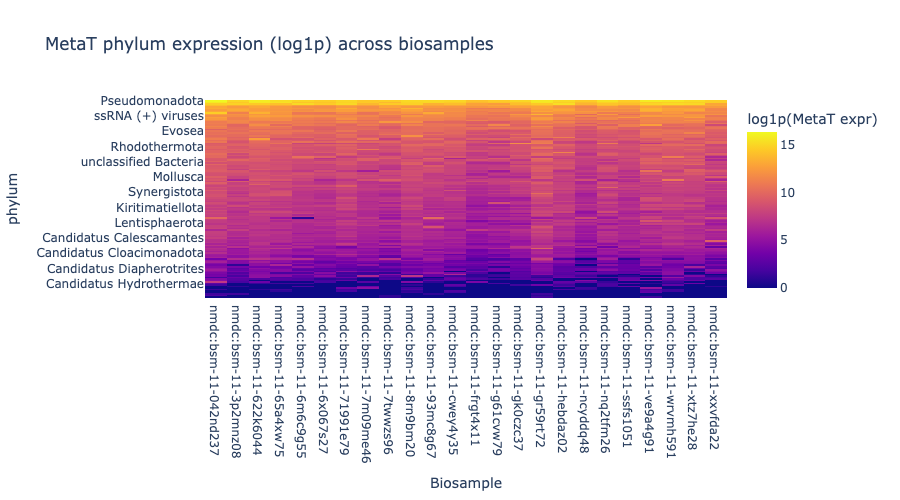

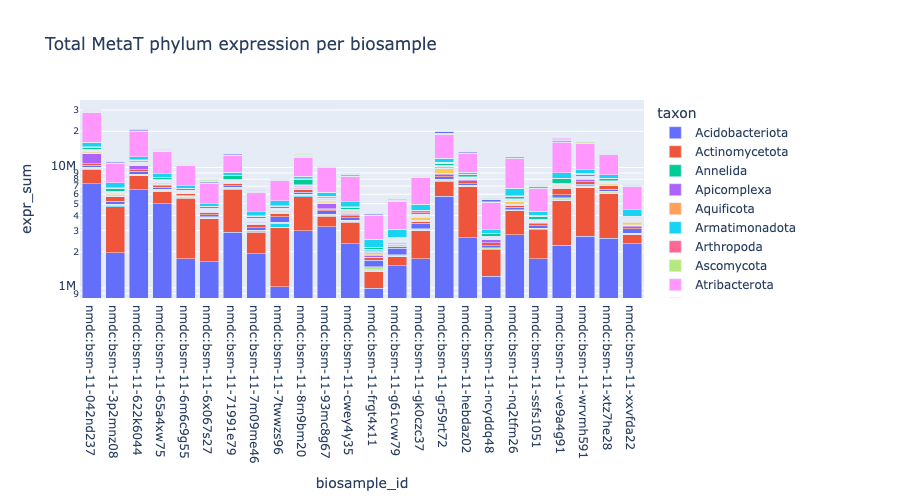

In [44]:

# Heatmaps for taxonomy
def plot_taxonomy_heatmaps(metaG_counts, metaT_expr, rank="phylum"):
    mg_html, mt_html = None, None
    if len(metaG_counts):
        mg_mat = metaG_counts.pivot_table(index="taxon", columns="biosample_id", values="count", fill_value=0)
        mg_mat = mg_mat.loc[mg_mat.sum(axis=1).sort_values(ascending=False).index]
        fig1 = px.imshow(mg_mat, labels=dict(x="Biosample", y=f"{rank}", color="MetaG gene count"), aspect="auto",
                         title=f"MetaG {rank} counts across biosamples")
        fig1.write_html(os.path.join(OUTPUT_DIR, f"heatmap_metaG_{rank}_counts.html"), include_plotlyjs="cdn", full_html=True)
        fig1.show(renderer="png",width=900)
        figbar = px.bar(metaG_counts, barmode="stack", x="biosample_id", y="count", color="taxon", log_y=True,
                        title=f"Total MetaG {rank} counts per biosample")
        figbar.write_html(os.path.join(OUTPUT_DIR, f"barchart_metaG_{rank}_total_counts.html"), include_plotlyjs="cdn", full_html=True)
        figbar.show(renderer="png",width=900)
    if len(metaT_expr):
        tmp = metaT_expr.copy(); tmp["log_expr"] = np.log1p(tmp["expr_sum"].astype(float))
        mt_mat = tmp.pivot_table(index="taxon", columns="biosample_id", values="log_expr", fill_value=0.0)
        mt_mat = mt_mat.loc[mt_mat.sum(axis=1).sort_values(ascending=False).index]
        fig2 = px.imshow(mt_mat, labels=dict(x="Biosample", y=f"{rank}", color="log1p(MetaT expr)"), aspect="auto",
                         title=f"MetaT {rank} expression (log1p) across biosamples")
        fig2.write_html(os.path.join(OUTPUT_DIR, f"heatmap_metaT_{rank}_expression.html"), include_plotlyjs="cdn", full_html=True)
        fig2.show(renderer="png",width=900)
        figbar2 = px.bar(metaT_expr, barmode="stack", x="biosample_id", y="expr_sum", color="taxon", log_y=True,
                         title=f"Total MetaT {rank} expression per biosample")
        figbar2.write_html(os.path.join(OUTPUT_DIR, f"barchart_metaT_{rank}_total_expression.html"), include_plotlyjs="cdn", full_html=True)
        figbar2.show(renderer="png",width=900)

plot_taxonomy_heatmaps(metaG_counts_kingdom, metaT_expr_kingdom, rank="kingdom")
plot_taxonomy_heatmaps(metaG_counts_phylum, metaT_expr_phylum, rank="phylum")


Taxonomy Overlap Analysis

For each biosample and each taxonomic rank (e.g. kingdom, phylum, class, order, family, genus, species):
	1.	Parse MetaG lineage → get the set of taxa names at that rank.
	2.	Parse MetaT lineage → get the set of taxa names at that rank.
	3.	Compute:
	•	n_metag_taxa = number of taxa found in MetaG at this rank
	•	n_metat_taxa = number of taxa found in MetaT at this rank
	•	n_shared_taxa = size of intersection
	•	n_metag_only = MetaG-only taxa
	•	n_metat_only = MetaT-only taxa
	•	jaccard = |shared| / |union|
	4.	Store results in a long table:

Visualizations:
	•	Stacked bar (shared vs unique taxa) per biosample × rank
	•	Heatmap (shared taxa counts or Jaccard) across biosamples × ranks

In [21]:
# 7) Taxonomy overlap analysis (MetaG vs MetaT) across ranks
def taxonomy_overlap_stats(datastore, ranks=None):
    if ranks is None:
        ranks = ["kingdom","phylum","class","order","family","genus","species"]
    rows = []
    for biosample_id, items in datastore.items():
        mg_lin = parse_lineage_df(items.get("metag_lineage_results"))
        mt_lin = parse_lineage_df(items.get("metat_lineage_results"))
        for rank in ranks:
            if rank not in mg_lin.columns or rank not in mt_lin.columns:
                continue
            mg_set = set(mg_lin[rank].dropna().unique())
            mt_set = set(mt_lin[rank].dropna().unique())
            shared = mg_set & mt_set
            rows.append({
                "biosample_id": biosample_id,
                "rank": rank,
                "n_metag_taxa": len(mg_set),
                "n_metat_taxa": len(mt_set),
                "n_shared_taxa": len(shared),
                "n_metag_only": len(mg_set - mt_set),
                "n_metat_only": len(mt_set - mg_set),
                "jaccard": (len(shared) / len(mg_set | mt_set)) if (mg_set or mt_set) else float("nan")
            })
    return pd.DataFrame(rows)

tax_overlap_df = taxonomy_overlap_stats(datastore)
tax_overlap_df.to_csv(os.path.join(OUTPUT_DIR, "taxonomy_overlap_summary.csv"), index=False)
tax_overlap_df.head(20)

,biosample_id,rank,n_metag_taxa,n_metat_taxa,n_shared_taxa,n_metag_only,n_metat_only,jaccard
0,nmdc:bsm-11-042nd237,kingdom,4,4,4,0,0,1.000000
1,nmdc:bsm-11-042nd237,phylum,120,125,116,4,9,0.899225
2,nmdc:bsm-11-042nd237,class,272,290,269,3,21,0.918089
...,...,...,...,...,...,...,...,...
17,nmdc:bsm-11-622k6044,order,526,540,514,12,26,0.931159
18,nmdc:bsm-11-622k6044,family,1163,1178,1127,36,51,0.928336
19,nmdc:bsm-11-622k6044,genus,4824,4430,4289,535,141,0.863847


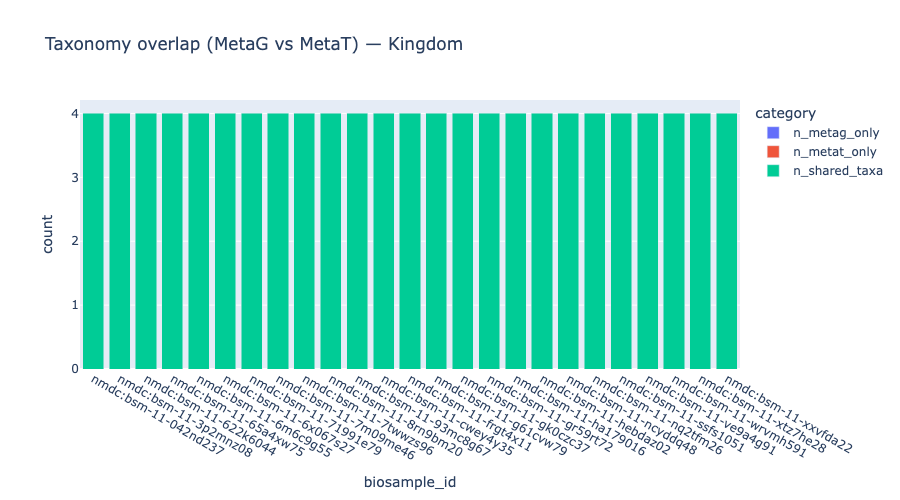

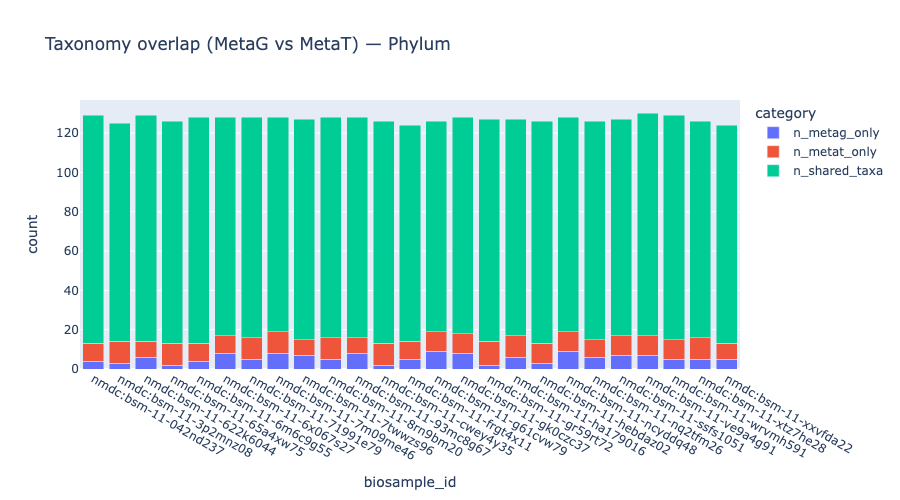

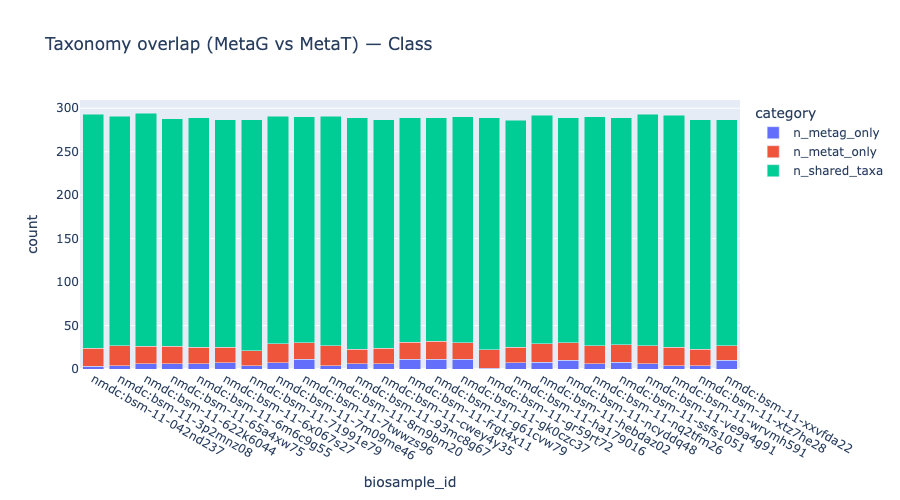

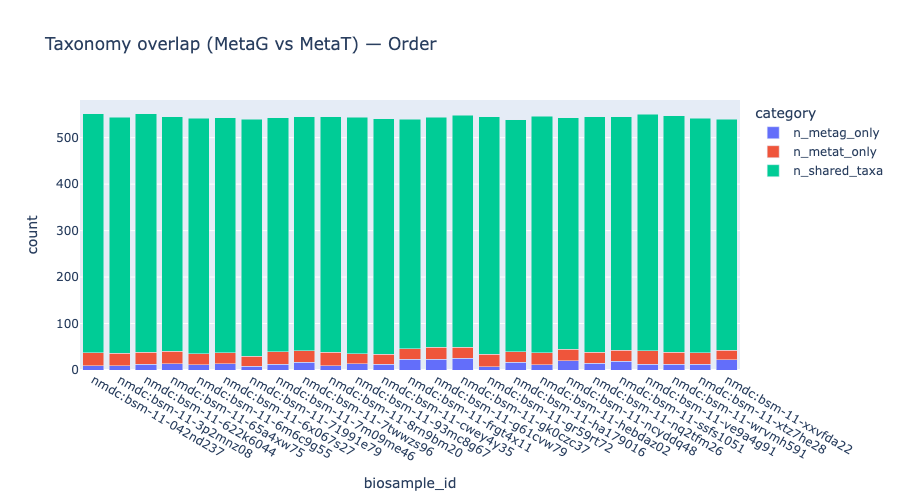

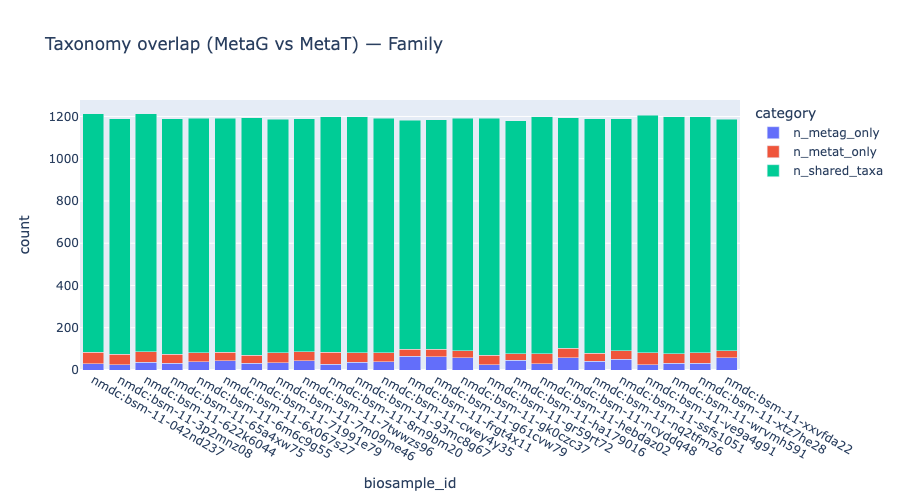

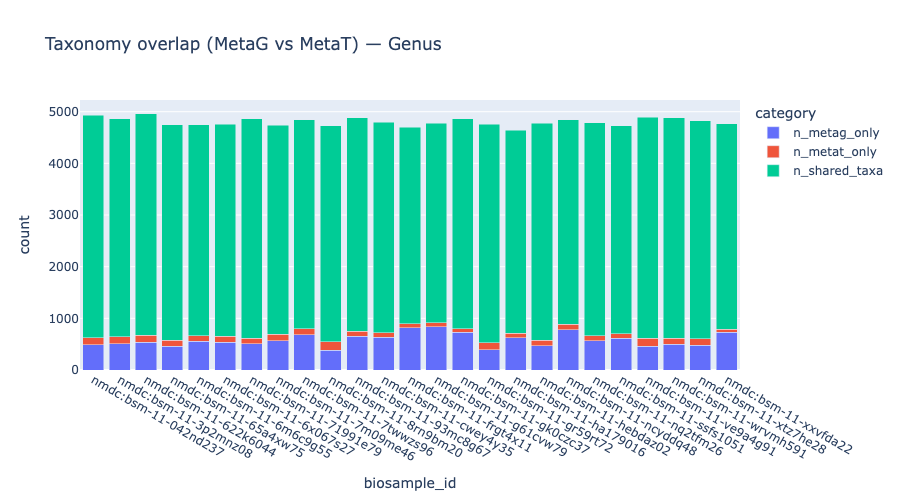

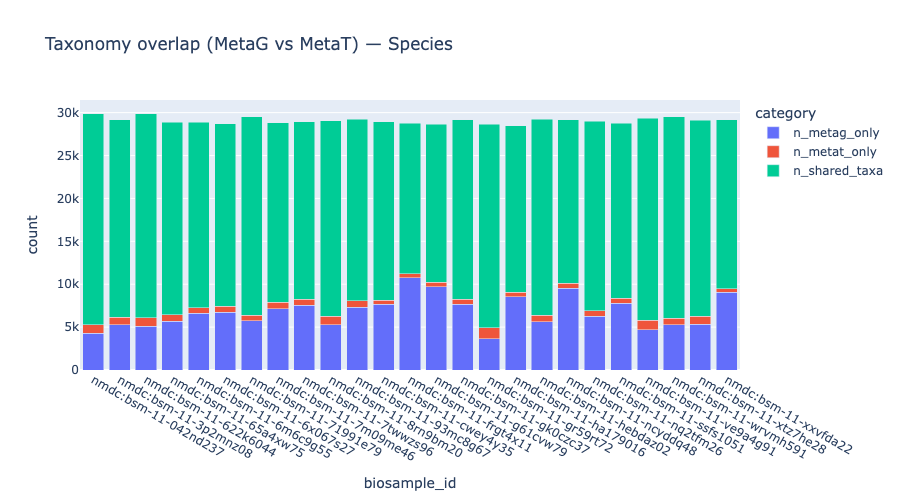

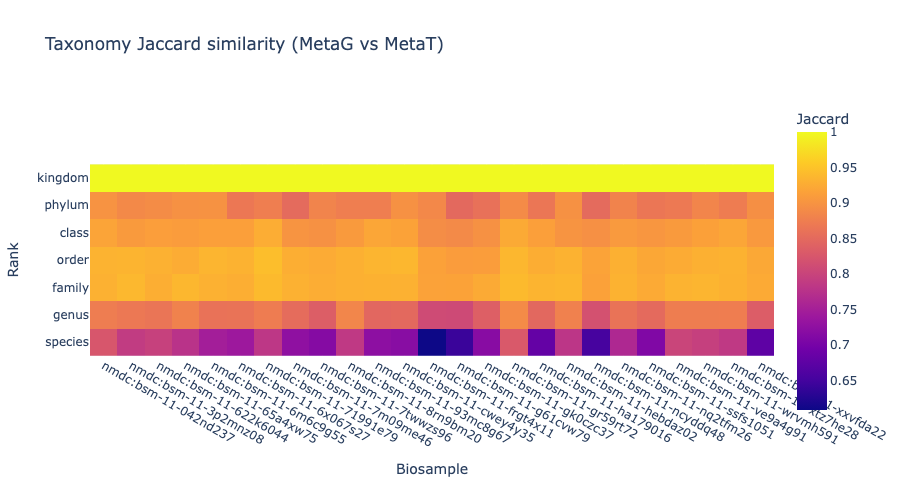

In [43]:
# Stacked bar: shared vs unique taxa, grouped by rank
rank_order = ["kingdom","phylum","class","order","family","genus","species"]
if len(tax_overlap_df):
    for r in rank_order:
        sub = tax_overlap_df[tax_overlap_df["rank"] == r].copy()
        if len(sub) == 0:
            continue
        df_long = sub.melt(
            id_vars=["biosample_id"],
            value_vars=["n_metag_only","n_metat_only","n_shared_taxa"],
            var_name="category",
            value_name="count"
        )
        fig = px.bar(
            df_long, x="biosample_id", y="count", color="category",
            barmode="stack",
            title=f"Taxonomy overlap (MetaG vs MetaT) — {r.capitalize()}"
        )
        out_html = os.path.join(OUTPUT_DIR, f"taxonomy_overlap_barchart_{r}.html")
        fig.write_html(out_html, include_plotlyjs="cdn", full_html=True)
        fig.show(renderer="png",width=900)

# Heatmap of Jaccard index (biosample × rank)
if len(tax_overlap_df):
    mat = tax_overlap_df.pivot(index="rank", columns="biosample_id", values="jaccard")
    # Reindex rows using the requested order (keep only ranks that appear)
    present_ranks = [r for r in rank_order if r in mat.index]
    mat = mat.reindex(present_ranks)
    fig2 = px.imshow(mat, labels=dict(x="Biosample", y="Rank", color="Jaccard"),
                     title="Taxonomy Jaccard similarity (MetaG vs MetaT)")
    fig2.write_html(os.path.join(OUTPUT_DIR, "taxonomy_overlap_jaccard_heatmap.html"), include_plotlyjs="cdn", full_html=True)
    fig2.show(renderer="png",width=900)

Ecosystem-level Analysis Plan

With specific_ecosystem available in biosample_metadata.csv, you can extend the overlap analyses like this:

1. KO Overlap by Ecosystem
	•	Merge ko_overlap_summary.csv with biosample_metadata.csv.
	•	Group by specific_ecosystem and compute:
	•	Mean/median n_shared_ko, n_metag_only, n_metat_only.
	•	Distribution plots (boxplot/violin).
	•	Visualization:
	•	Violin/box plots: n_shared_ko across ecosystems.
	•	Stacked bar: average shared vs unique KO counts per ecosystem.

2. Taxonomy Overlap by Ecosystem
	•	Merge taxonomy_overlap_summary.csv with biosample_metadata.csv.
	•	Group by specific_ecosystem × rank.
	•	Compute averages of n_shared_taxa, jaccard.
	•	Visualization:
	•	Faceted box/violin plots: Jaccard index per ecosystem at each rank.
	•	Heatmap: ecosystems (x-axis) vs ranks (y-axis), colored by average Jaccard.

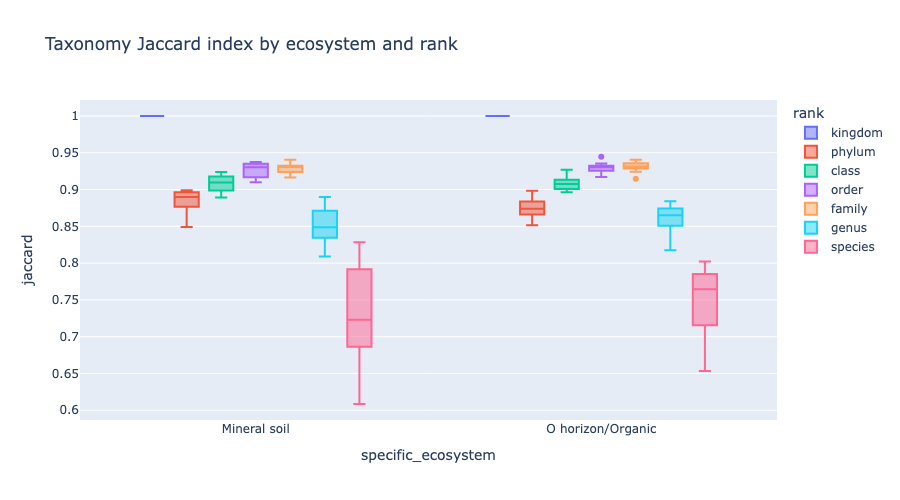

In [ ]:
tax_with_meta = tax_overlap_df.merge(biosample_metadata[["biosample_id", "specific_ecosystem"]], on="biosample_id", how="left")
# Taxonomy overlap differences across ecosystems
if len(tax_with_meta):
    fig1 = px.box(tax_with_meta, x="specific_ecosystem", y="jaccard", color="rank",
                  title="Taxonomy Jaccard index by ecosystem and rank")
    fig1.show(renderer="png",width=900)  # use renderer="png" to show in some environments
   
